In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score


After the change made to the Github, you can just simply run the cells below.

In [ ]:
path_train = 'https://raw.githubusercontent.com/EliabethValdez/ADA/main/assignment_1/data_train_final.csv'
df = pd.read_csv(path_train, parse_dates= True)

In [ ]:
path_test = 'https://raw.githubusercontent.com/EliabethValdez/ADA/main/assignment_1/data_test_final.csv'
df_test = pd.read_csv(path_test, parse_dates = True)

<h1>  <u> Counts model</u></h1>
In the first model, we will consider as our variable set the following variables. Included in this set are the count variables created in the other notebook.
We convert these into the correct data type and use pandas to get their dummy representations.

In [ ]:
Cat_var = list(['homebanking_active_count',
               'has_homebanking_count',
               'has_insurance_21_count',
               'has_insurance_23_count',
               'has_life_insurance_fixed_cap_count',
               'has_life_insurance_decreasing_cap_count',
               'has_fire_car_other_insurance_count',
               'has_personal_loan_count',
               'has_mortgage_loan_count',
               'has_current_account_count',
               'has_pension_saving_count',
               'has_savings_account_count',
               'has_current_account_starter_count',
               'gender',
               "customer_relationship_cat",
               'customer_children_cat',
               'insurance_count',
               'savings_count',
               'loan_count',
               'has_account_count', 'customer_self_employed_count']
               )
dummies = pd.get_dummies(df[Cat_var].astype('O'))

Below are the continuous variables includes in hte model. Notice that we use the diff variables defined in the other notebook, aswell as the Months on Books variable and the debt ratio.

In [ ]:
Cont_var = list([
    'mob',
    'age',
    'bal_insurance_21_diff',
    'bal_insurance_23_diff',
    'cap_life_insurance_fixed_cap_diff',
    'cap_life_insurance_decreasing_cap_diff',
    'prem_fire_car_other_insurance_diff',
    'bal_personal_loan_diff',
    'bal_mortgage_loan_diff',
    'bal_current_account_diff',
    'bal_pension_saving_diff',
    'bal_savings_account_diff',
    'bal_savings_account_starter_diff',
    'bal_current_account_starter_diff',
    'debt_ratio_diff'
])
cts = df[Cont_var]


We define the relevant data sets, and then split them in a stratified split for training and validation.
A stratified split ensures us that the training and the validation set both have a similar amount of churners and non-churners, which is an important characteristic.

In [ ]:
X = pd.concat((cts,dummies),axis=1)

In [ ]:
y = df['target']

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify=y, random_state=23)


We also do the same thing for the test data.

In [ ]:
len(list(df_test))

114

In [ ]:
list(df_test)

['client_id',
 'customer_since_all',
 'customer_since_bank',
 'customer_gender',
 'customer_birth_date',
 'customer_postal_code',
 'customer_occupation_code',
 'customer_education',
 'homebanking_active_3',
 'has_homebanking_3',
 'has_insurance_21_3',
 'has_insurance_23_3',
 'has_life_insurance_fixed_cap_3',
 'has_life_insurance_decreasing_cap_3',
 'has_fire_car_other_insurance_3',
 'has_personal_loan_3',
 'has_mortgage_loan_3',
 'has_current_account_3',
 'has_pension_saving_3',
 'has_savings_account_3',
 'has_savings_account_starter_3',
 'has_current_account_starter_3',
 'bal_insurance_21_3',
 'bal_insurance_23_3',
 'cap_life_insurance_fixed_cap_3',
 'cap_life_insurance_decreasing_cap_3',
 'prem_fire_car_other_insurance_3',
 'bal_personal_loan_3',
 'bal_mortgage_loan_3',
 'bal_current_account_3',
 'bal_pension_saving_3',
 'bal_savings_account_3',
 'bal_savings_account_starter_3',
 'bal_current_account_starter_3',
 'visits_distinct_so_3',
 'visits_distinct_so_areas_3',
 'customer_self_

In [ ]:
dummies_test = pd.get_dummies(df_test[Cat_var].astype('O'))
cts_test = df_test[Cont_var]
Testset = pd.concat((cts_test,dummies_test),axis=1)

We now consider several models. All of these are finetuned using a gridsearch, and extracting the model that performs best on the training data. Notice that we use stratified folds, which ensures once again that our folds have a similar number of churners. In our pipeline, we notice furthermore that we scale the data using a standard scaler (which just standardizes the data), our classifier is the random forest classifier (an ensemble method) and we have several parameters we finetune over.

In [ ]:
cv = StratifiedKFold(n_splits=6)
pipe1 = Pipeline([('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=23))
                ])
params1 = {
    "classifier__class_weight": ["balanced"],
    "classifier__max_depth": np.arange(1, 9),
    "classifier__n_estimators": [50, 150, 250],
    "classifier__max_features": [None, "log2"]
}
gridsearch_11 = GridSearchCV(pipe1, params1, verbose=0, cv=cv,
                          scoring='balanced_accuracy', n_jobs=10).fit(X_train, y_train)
print(gridsearch_11.best_score_, gridsearch_11.score(X_test, y_test))


0.6762374616982013 0.6739604650674758


In [ ]:
df_test['Pred1'] = gridsearch_11.predict_proba(Testset)[:,1]

To visualize the confusion matrix for each class, we express the results in percentages.

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

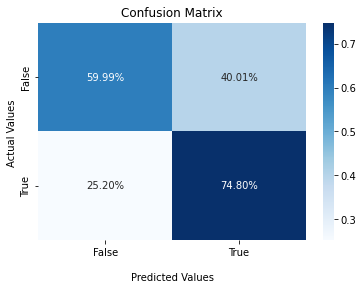

In [ ]:
pred_11 = gridsearch_11.predict(X_test)
cm1 = confusion_matrix(y_test, pred_11)
dd1 = [np.sum(cm1[0, :]), np.sum(cm1[1, :])]

ax = sns.heatmap([cm1[0, :]/dd1[0], cm1[1, :]/dd1[1]], annot=True,
                 fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])



The second type of model considered is the Logistic Regression model. Here, we use a minmax scaler (which scales the data from 0 to 1). 

In [ ]:
cv = StratifiedKFold(n_splits=6)
pipe2 = Pipeline([('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression())
                ])
params2 = {
    'classifier__class_weight': ["balanced"],
    'classifier__solver': ['saga', 'newton-cg','lfbgs'],
    'classifier__max_iter': [50, 100, 150,500],
    'classifier__multi_class': ['auto'],
    'classifier__penalty': ['l1', 'l2','elasticnet']
}
gridsearch2 = GridSearchCV(pipe2, params2, verbose=0, cv=cv,
                          scoring='balanced_accuracy', n_jobs=10).fit(X_train, y_train)
print(gridsearch2.best_score_, gridsearch2.score(X_test, y_test))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
144 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  F

0.6540728847863955 0.6483340704130004


We see that the confusion matrix performs better for the first class, but worse for the second. Because the metric used looks at the performance on the second class, this model might not be the most interesting.

In [ ]:
df_test['Pred2'] = gridsearch2.predict_proba(Testset)[:,1]

NameError: ignored

In [ ]:
Results_1 = df_test[['client_id','Pred1']]
Results_2 = df_test[['client_id','Pred2']]

In [ ]:
Results_1 = Results_1.rename(columns={'client_id':'ID', 'Pred1':'PROB'})
Results_2 = Results_2.rename(columns={'client_id':'ID', 'Pred2':'PROB'})

In [ ]:
Results_1.to_csv('RFC.csv', index=False)
Results_2.to_csv('LR.csv', index=False)

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

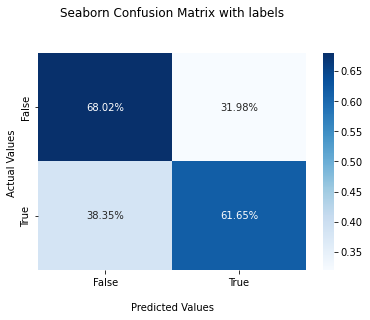

In [ ]:
pred2 = gridsearch2.predict(X_test)
cm2 = confusion_matrix(y_test, pred2)
dd2 = [np.sum(cm2[0, :]), np.sum(cm2[1, :])]

ax = sns.heatmap([cm2[0,:]/dd2[0], cm2[1,:]/dd2[1]],annot=True,
                 fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])


Finally,  the final model we consider is the linear SVC.

In [ ]:
cv = StratifiedKFold(n_splits=6)
pipeSVM = Pipeline([('scaler', MinMaxScaler()),
                ('classifier', LinearSVC(random_state=23))
                ])
params2 = {
    'classifier__class_weight': ["balanced"],
    'classifier__max_iter': [50, 100, 150,500],
    'classifier__multi_class': ['ovr','crammer_singer'],
    'classifier__penalty': ['l1', 'l2']
}
gridsearchSVM = GridSearchCV(pipeSVM, params2, verbose=0, cv=cv,
                          scoring='balanced_accuracy', n_jobs=10).fit(X_train, y_train)
print(gridsearchSVM.best_score_, gridsearchSVM.score(X_test, y_test))

The model seems to perform quite well on the second class, but terribly on the first class.

In [ ]:
df_test['SVM1']= gridsearchSVM.predict_proba(Testset)[:,1]

In [ ]:
predSVM = gridsearchSVM.predict(X_test)
cmSVM = confusion_matrix(y_test, predSVM)
ddSVM = [np.sum(cmSVM[0, :]), np.sum(cmSVM[1, :])]

ax = sns.heatmap([cmSVM[0,:]/ddSVM[0], cmSVM[1,:]/ddSVM[1]],annot=True,
                 fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])


<h1> <u> Seq model</u></h1>

This part heavily resembles the previous part, but now we use another variable set. Here, we use the seq variables defined in the other notebook. This will lead to more precise information regarding the time series of the variables, at the cost of a larger amount of variables.

In [ ]:
Cat_var2 = list(['homebanking_active_seq',
               'has_homebanking_seq',
               'has_insurance_21_seq',
               'has_insurance_23_seq',
               'has_life_insurance_fixed_cap_seq',
               'has_life_insurance_decreasing_cap_seq',
               'has_fire_car_other_insurance_seq',
               'has_personal_loan_seq',
               'has_mortgage_loan_seq',
               'has_current_account_seq',
               'has_pension_saving_seq',
               'has_savings_account_seq',
               'has_current_account_starter_seq',
               'gender',
               "customer_relationship_cat",
               'customer_children_cat',
               'insurance_seq',
               'savings_seq',
               'loan_seq',
               'has_account_seq', 'customer_self_employed_seq']
               )
dummies2 = pd.get_dummies(df[Cat_var2].astype('O'))
dummies2

,homebanking_active_seq_0,homebanking_active_seq_1,homebanking_active_seq_10,homebanking_active_seq_11,homebanking_active_seq_100,homebanking_active_seq_101,homebanking_active_seq_110,homebanking_active_seq_111,has_homebanking_seq_0,has_homebanking_seq_1,...,loan_seq_110,loan_seq_111,has_account_seq_111,customer_self_employed_seq_0,customer_self_employed_seq_1,customer_self_employed_seq_11,customer_self_employed_seq_100,customer_self_employed_seq_101,customer_self_employed_seq_110,customer_self_employed_seq_111
0,1,0,0,0,0,0,0,0,1,0,...,0,1,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63692,0,0,0,0,0,0,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
63693,1,0,0,0,0,0,0,0,1,0,...,0,1,1,1,0,0,0,0,0,0
63694,1,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
63695,1,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0


In [ ]:
X2 = pd.concat((cts,dummies2),axis=1)

NameError: ignored

In [ ]:
dummies_test2 = pd.get_dummies(df_test[Cat_var2].astype('O'))
cts_test = df_test[Cont_var]
Testset2 = pd.concat((cts_test,dummies_test2),axis=1)

As Abraham mentioned, there will be an issue when training. The reason for this lies in the fact that certain sequences (such as eg. 1 0 1) can appear in the traning set but not in the test set. However, each (observed) sequence gives rise to a variable, and hence if one of the sequences is not present the variable will also not be present. 

In [ ]:
print('The length of the training set is ' + str(len(list(X2))) + ' whilst the length of the test set is ' + str(len(list(Testset2))))

The lenght of the training set is 131 whilst the length of the test set is 128


The code below basically takes adds the missing columns to both sets.

In [ ]:
X2,Testset2 = X2.align(Testset2, join='outer', axis=1, fill_value=0)
print('The length of the training set is now ' + str(len(list(X2))) + ' and the length of the test set is ' + str(len(list(Testset2))))


The length of the training set is now 134 and the length of the test set is 134


In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size = 0.33, stratify=y, random_state=23)

In [ ]:
cv = StratifiedKFold(n_splits=6)
pipe3 = Pipeline([('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=23))
                 ])
params3 = {
    "classifier__class_weight": ["balanced"],
    "classifier__max_depth": np.arange(1, 9),
    "classifier__n_estimators": [50, 150, 250],
    "classifier__max_features": [None, "log2"]
}
gridsearch3 = GridSearchCV(pipe3, params3, verbose=0, cv=cv,
                          scoring='balanced_accuracy', n_jobs=10).fit(X_train2, y_train2)
print(gridsearch3.best_score_, gridsearch3.score(X_test2, y_test2))


0.6762978569245625 0.6739604650674758


In [ ]:
gridsearch3.predict_proba(Testset2)[:,1]

array([0.6423118 , 0.40469049, 0.63790944, ..., 0.27388378, 0.53045139,
       0.29328789])

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

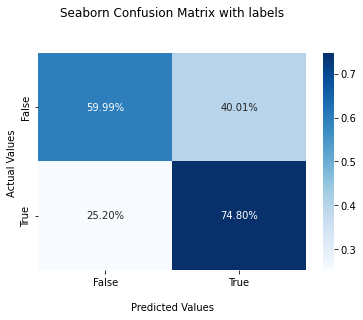

In [ ]:
pred3 = gridsearch3.predict(X_test2)
cm3 = confusion_matrix(y_test2, pred3)
dd3 = [np.sum(cm3[0, :]), np.sum(cm3[1, :])]

ax = sns.heatmap([cm3[0,:]/dd3[0], cm3[1,:]/dd3[1]],annot=True,
                 fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])


In [ ]:
cv = StratifiedKFold(n_splits=6)
pipe4 = Pipeline([('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression())
                ])
params4 = {
    'classifier__class_weight': ["balanced"],
    'classifier__solver': ['saga', 'newton-cg','lfbgs'],
    'classifier__max_iter': [50, 100, 150,500],
    'classifier__multi_class': ['auto'],
    'classifier__penalty': ['l1', 'l2','elasticnet']
}
gridsearch4 = GridSearchCV(pipe4, params4, verbose=0, cv=cv,
                          scoring='balanced_accuracy', n_jobs=10).fit(X_train2, y_train2)
print(gridsearch4.best_score_, gridsearch4.score(X_test2, y_test2))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
144 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  F

0.6516369251751105 0.6462588478706429


In [ ]:
df_test['Pred4']= gridsearch4.predict_proba(Testset)[:,1]

In [ ]:
pred4 = gridsearch4.predict(X_test2)
cm4 = confusion_matrix(y_test2, pred4)
dd4 = [np.sum(cm4[0, :]), np.sum(cm4[1, :])]

ax = sns.heatmap([cm4[0,:]/dd4[0], cm4[1,:]/dd4[1]],annot=True,
                 fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

In [ ]:
cv = StratifiedKFold(n_splits=6, random_state=23)
pipeSVM2 = Pipeline([('scaler', StandardScaler()),
                ('classifier', LinearSVC(random_state=23))
                 ])
params3 = {
    "classifier__class_weight": ["balanced"],
    "classifier__max_depth": np.arange(1, 9),
    "classifier__n_estimators": [50, 150, 250],
    "classifier__max_features": [None, "log2"]
}
gridsearchSVM2 = GridSearchCV(pipeSVM2, params3, verbose=0, cv=cv,
                          scoring='balanced_accuracy', n_jobs=10).fit(X_train2, y_train2)
print(gridsearchSVM2.best_score_, gridsearchSVM2.score(X_test2, y_test2))


In [ ]:
df_test['Svm2'] = gridsearchSVM2.predict_proba(Testset)[:,1]

In [ ]:
predSVM2 = gridsearchSVM2.predict(X_test2)
cmSVM2 = confusion_matrix(y_test2, predSVM2)
ddSVM2 = [np.sum(cmSVM2[0, :]), np.sum(cmSVM2[1, :])]

ax = sns.heatmap([cmSVM2[0,:]/ddSVM2[0], cmSVM2[1,:]/ddSVM2[1]],annot=True,
                 fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

In [ ]:
Results_1 = df_test[['client_id','Pred1']]
Results_2 = df_test[['client_id','Pred2']]
Results_svm1 = df_test[['client_id','SVM1']]
Results_3 = df_test[['client_id','Pred3']]
Results_4 = df_test[['client_id','Pred4']]
Results_svm2 = df_test[['client_id','SVM2']]

In [ ]:
Results_1.to_csv("pred1.csv",index=False)
Results_2.to_csv("pred2.csv",index=False)
Results_svm1.to_csv("pred_svm1.csv",index=False)
Results_3.to_csv("pred3.csv",index=False)
Results_4.to_csv("pred4.csv",index=False)
Results_svm2.to_csv("pred_svm2.csv",index=False)